# 📝 EDA Progress Log


In [75]:
import os
import pandas as pd
import matplotlib.pyplot as plt

## ✅ Load Data
- Loaded `flextrack-2025-training-data-v0.1.csv`
- Confirmed shape: **105,120 rows × 7 columns**
- Previewed first rows with `df_train.head()`

In [76]:
train_path = "../data/raw/flextrack-training-data-v0.1.csv"
df_train = pd.read_csv(train_path)

In [77]:
print("Shape:", df_train.shape)
df_train.head()

Shape: (105120, 7)


,Site,Timestamp_Local,Dry_Bulb_Temperature_C,Global_Horizontal_Radiation_W/m2,Building_Power_kW,Demand_Response_Flag,Demand_Response_Capacity_kW
0,siteA,2019-01-01 00:00:00,22.20,0.0,4.8,0,0.0
1,siteA,2019-01-01 00:15:00,22.27,0.0,4.8,0,0.0
2,siteA,2019-01-01 00:30:00,22.35,0.0,4.8,0,0.0
3,siteA,2019-01-01 00:45:00,22.42,0.0,4.8,0,0.0
4,siteA,2019-01-01 01:00:00,22.50,0.0,4.8,0,0.0


## ✅ Target Variable Exploration
- Computed global class distribution for `Demand_Response_Flag`:
  - `0` ≈ 97.04%
  - `-1` ≈ 2.15%
  - `+1` ≈ 0.81%
- Computed per-site counts of `Demand_Response_Flag` (`siteA`, `siteB`, `siteC`)

In [78]:
print("Class distribution (counts):")
print(df_train["Demand_Response_Flag"].value_counts())


Class distribution (counts):
Demand_Response_Flag
 0    102011
-1      2262
 1       847
Name: count, dtype: int64


In [79]:
print("Class distribution (percentage):")
print(df_train["Demand_Response_Flag"].value_counts(normalize=True) * 100)

Class distribution (percentage):
Demand_Response_Flag
 0    97.042428
-1     2.151826
 1     0.805746
Name: proportion, dtype: float64


In [80]:
print("Flag distribution per site:")
print(df_train.groupby("Site")["Demand_Response_Flag"].value_counts().unstack(fill_value=0))

Flag distribution per site:
Demand_Response_Flag   -1      0    1
Site                                 
siteA                 631  34269  140
siteB                 676  33931  433
siteC                 955  33811  274


## ✅ Quick Visualization
- Plotted a sample slice (`siteA` rows 2000–3000):
  - Blue line: `Building_Power_kW`
  - Red points: `Demand_Response_Flag` (scaled)  
- Purpose: eyeball how rare/subtle DR events are within daily load cycles

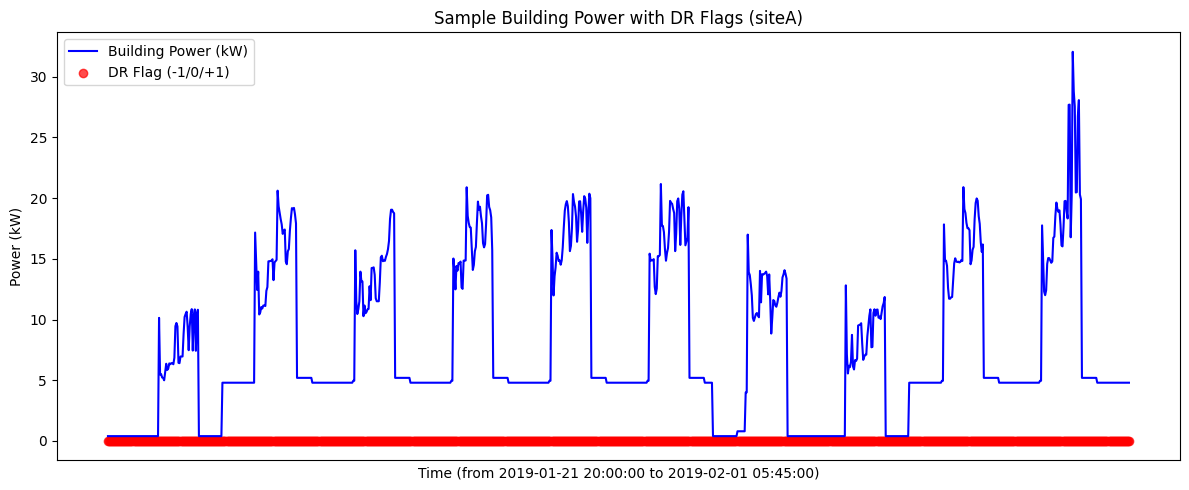

In [81]:
siteA_sample = df_train[df_train["Site"] == "siteA"].iloc[2000:3000]

plt.figure(figsize=(12, 5))
plt.plot(siteA_sample["Timestamp_Local"], siteA_sample["Building_Power_kW"], label="Building Power (kW)", color="blue")
plt.scatter(siteA_sample["Timestamp_Local"], siteA_sample["Demand_Response_Flag"], color="red", label="DR Flag (-1/0/+1)", alpha=0.7)

plt.title("Sample Building Power with DR Flags (siteA)")
plt.xlabel(f"Time (from {siteA_sample['Timestamp_Local'].iloc[0]} "
           f"to {siteA_sample['Timestamp_Local'].iloc[-1]})")
plt.ylabel("Power (kW)")
plt.legend()

# Remove x-axis tick labels
plt.xticks([])

plt.tight_layout()
plt.show()

## 🎯 Key Takeaways (so far)
- **Severe class imbalance** (events are rare, especially `+1`)
- Events appear **subtle** relative to normal daily variability
- Sites differ in event frequencies → generalization across sites will matter

## ✅ Datetime Parsing & Sanity Checks
- Converted `Timestamp_Local` to `datetime64[ns]` successfully (no parsing errors).
- Verified date ranges per site:
  - **siteA**: 2019-01-01 → 2019-12-31
  - **siteB**: 2019-01-01 → 2019-12-31
  - **siteC**: 2023-01-01 → 2023-12-31
- Sorted dataset by `Site` and `Timestamp_Local` to prepare for time-aware CV and feature engineering.

In [82]:

df_train["Timestamp_Local"] = pd.to_datetime(df_train["Timestamp_Local"], errors="raise")
df_train = df_train.sort_values(["Site", "Timestamp_Local"]).reset_index(drop=True)

print(df_train["Timestamp_Local"].dtype)
print(df_train.groupby("Site")["Timestamp_Local"].agg(["min","max"]).reset_index())


datetime64[ns]
    Site        min                 max
0  siteA 2019-01-01 2019-12-31 23:45:00
1  siteB 2019-01-01 2019-12-31 23:45:00
2  siteC 2023-01-01 2023-12-31 23:45:00


## ✅ Event Distribution by Hour of Day
- Calculated probability of DR events across 24 hours
- **Findings:**
  - No events occur before 10:00 or after 17:00
  - Peak event window: **11:00–17:00**
  - Highest event rate ≈ **10.5%** (13:00–17:00)
- **Implication:** Hour of day is a critical predictive feature; models should focus on business hours to avoid false positives.


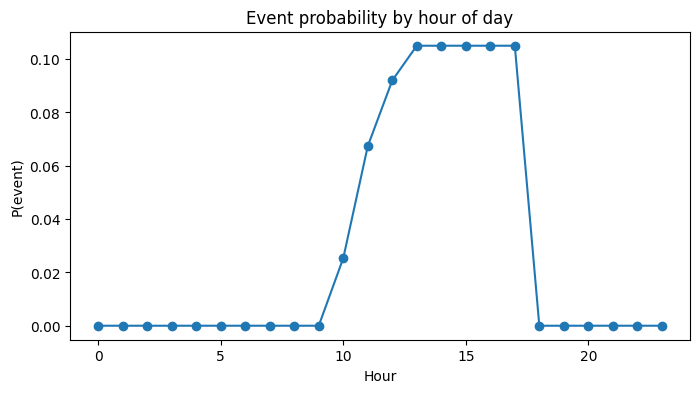

In [83]:
df_train["hour"] = df_train["Timestamp_Local"].dt.hour
event_by_hour = df_train.groupby("hour")["Demand_Response_Flag"].apply(lambda x: (x!=0).mean())

plt.figure(figsize=(8,4))
plt.plot(event_by_hour.index, event_by_hour.values, marker="o")
plt.title("Event probability by hour of day")
plt.xlabel("Hour")
plt.ylabel("P(event)")
plt.show()

## ✅ Event Distribution by Day of Week
- Computed event probability for each day (0=Mon … 6=Sun)
- **Findings:**
  - Events occur consistently on weekdays (~2.5–4.0%)
  - Friday has the highest rate (~4.0%)
  - Weekends, especially Sunday (~2.1%), show fewer events
- **Implication:** Day-of-week is a useful context feature; weekends likely need different treatment from weekdays.

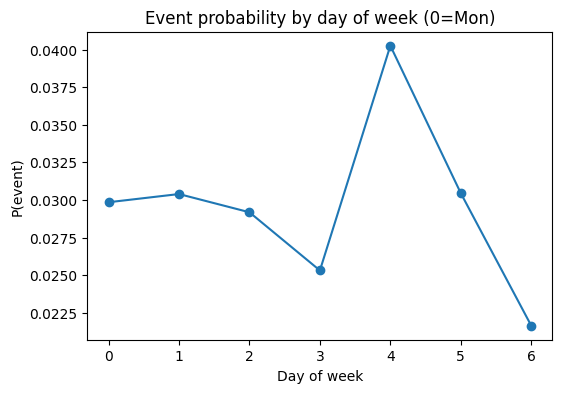

In [84]:
df_train["dow"] = df_train["Timestamp_Local"].dt.dayofweek
event_by_dow = df_train.groupby("dow")["Demand_Response_Flag"].apply(lambda x: (x!=0).mean())

plt.figure(figsize=(6,4))
plt.plot(event_by_dow.index, event_by_dow.values, marker="o")
plt.title("Event probability by day of week (0=Mon)")
plt.xlabel("Day of week")
plt.ylabel("P(event)")
plt.show()

## ✅ Event Distribution by Month
- Computed event probability by month (1=Jan … 12=Dec)
- **Findings:**
  - Events cluster in **Jan–Feb, Jun–Aug, and Dec**
  - No events in Mar–May or Sep–Nov
  - Highest rate: **December (~8.5%)**
- **Implication:** Strong seasonal signal; month/season features will be valuable for detecting events.


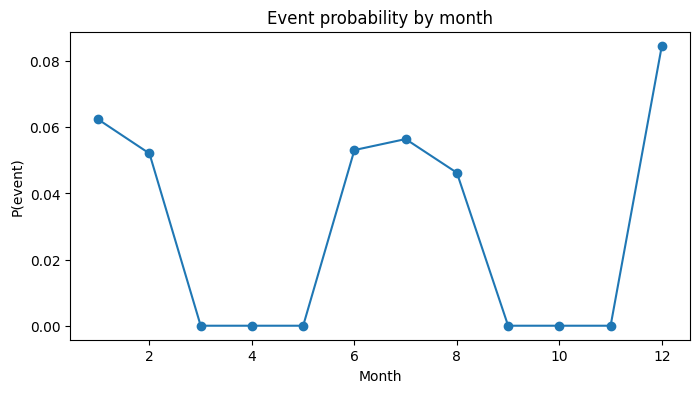

In [85]:
df_train["month"] = df_train["Timestamp_Local"].dt.month
event_by_month = df_train.groupby("month")["Demand_Response_Flag"].apply(lambda x: (x!=0).mean())

plt.figure(figsize=(8,4))
plt.plot(event_by_month.index, event_by_month.values, marker="o")
plt.title("Event probability by month")
plt.xlabel("Month")
plt.ylabel("P(event)")
plt.show()

## ✅ Weather Context During Events
- Compared distributions of temperature and radiation by DR flag
- **Findings:**
  - Events occur in **warmer conditions** (avg ~19–21 °C vs 17.6 °C baseline)
  - Events strongly tied to **daytime with high solar radiation** (~600 W/m²)
- **Implication:** Temperature and radiation are critical predictors; DR events are concentrated in hot, sunny periods.


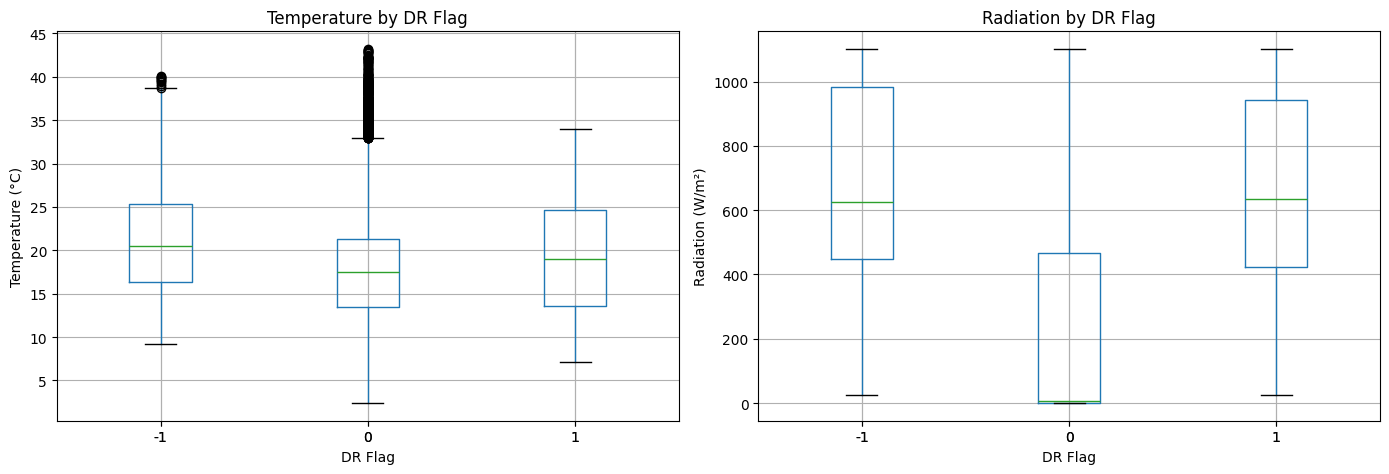

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

df_train.boxplot(column="Dry_Bulb_Temperature_C", by="Demand_Response_Flag", ax=axes[0])
axes[0].set_title("Temperature by DR Flag")
axes[0].set_xlabel("DR Flag")
axes[0].set_ylabel("Temperature (°C)")

df_train.boxplot(column="Global_Horizontal_Radiation_W/m2", by="Demand_Response_Flag", ax=axes[1])
axes[1].set_title("Radiation by DR Flag")
axes[1].set_xlabel("DR Flag")
axes[1].set_ylabel("Radiation (W/m²)")

plt.suptitle("") 
plt.tight_layout()
plt.show()

## ✅ Event Duration Analysis
- Measured continuous event lengths (15-min resolution)
- **Findings:**
  - -1 events: almost always **~6 hours** (very consistent)
  - +1 events: shorter, avg ~2.7h, more variable (1–7h)
- **Implication:**
  - Models must capture **multi-hour load patterns**
  - Rolling features (1h, 3h, 6h) and persistence signals will be critical


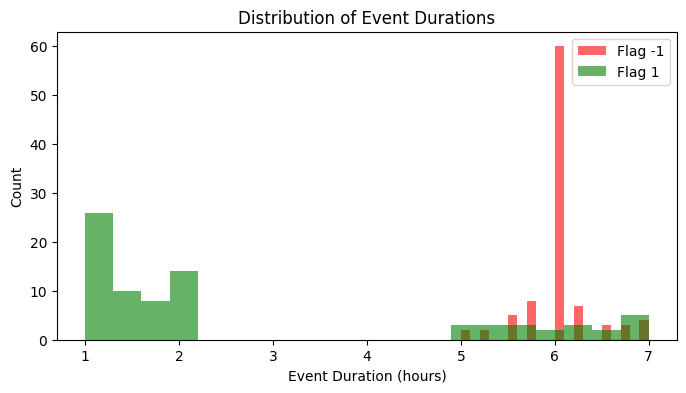

In [87]:
durations = []

for site, df_site in df_train.groupby("Site"):
    flag_series = df_site["Demand_Response_Flag"].reset_index(drop=True)
    current_flag, length = 0, 0
    
    for flag in flag_series:
        if flag == current_flag and flag != 0:
            length += 1
        else:
            if current_flag != 0:  # event ended
                durations.append({"Site": site, "Flag": current_flag, "Length": length})
            current_flag = flag
            length = 1 if flag != 0 else 0
    
    # catch last event
    if current_flag != 0:
        durations.append({"Site": site, "Flag": current_flag, "Length": length})

df_durations = pd.DataFrame(durations)
df_durations["Hours"] = df_durations["Length"] * 0.25  # 15 min steps

plt.figure(figsize=(8,4))
for flag, color in [(-1,"red"), (1,"green")]:
    subset = df_durations[df_durations["Flag"]==flag]
    plt.hist(subset["Hours"], bins=20, alpha=0.6, label=f"Flag {flag}", color=color)
plt.xlabel("Event Duration (hours)")
plt.ylabel("Count")
plt.title("Distribution of Event Durations")
plt.legend()
plt.show()

## ✅ Capacity Distribution Analysis
- Explored `Demand_Response_Capacity_kW` for non-zero events
- **Findings:**
  - Distribution is skewed with many small events and a few very large outliers
  - -1 events: mean ≈ -9.1 kW (down to -129 kW)
  - +1 events: mean ≈ +14.3 kW (up to +148 kW)
- **Implication:**
  - Regression will need robust methods (log-transform, Huber/quantile loss)
  - Correct flag prediction is critical; otherwise regression output is irrelevant


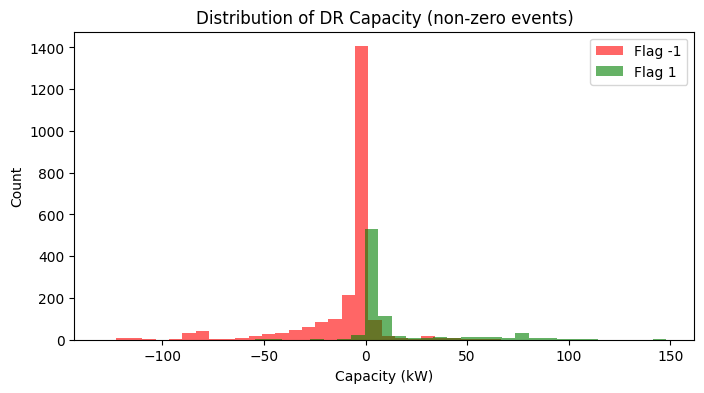

In [88]:
df_events = df_train[df_train["Demand_Response_Flag"] != 0]

plt.figure(figsize=(8,4))
for flag, color in [(-1,"red"), (1,"green")]:
    subset = df_events[df_events["Demand_Response_Flag"]==flag]
    plt.hist(subset["Demand_Response_Capacity_kW"], bins=30, alpha=0.6, label=f"Flag {flag}", color=color)
plt.xlabel("Capacity (kW)")
plt.ylabel("Count")
plt.title("Distribution of DR Capacity (non-zero events)")
plt.legend()
plt.show()

## ✅ Building Power Analysis
- **Daily cycle:**
  - siteC shows strong midday peaks (~300 kW), sites A/B much smaller (~5–15 kW)
  - Confirms sites differ in power scale → may need normalization or site-specific handling
- **Lag correlations (siteA):**
  - lag_1 (15min): 0.94, lag_4 (1h): 0.83, lag_12 (3h): 0.57, lag_24 (6h): 0.24
  - Strong autocorrelation at short lags, moderate at multi-hour lags
- **Implication:**
  - Lag/rolling features (15min, 1h, 3h, 6h) will be critical
  - Site-level differences should be accounted for in feature design


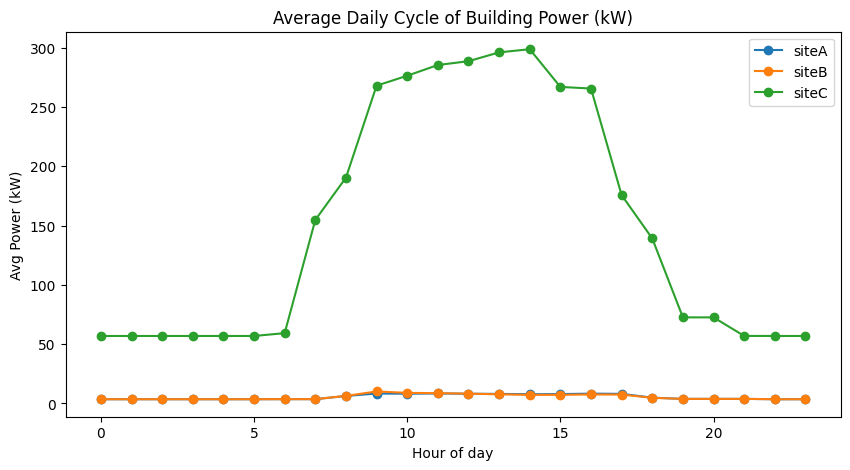

Lag correlations with Building_Power_kW (siteA):
Dry_Bulb_Temperature_C              0.325044
Global_Horizontal_Radiation_W/m2    0.567247
Demand_Response_Flag                0.001143
Demand_Response_Capacity_kW         0.090011
hour                                0.103807
dow                                 0.388768
month                              -0.125993
lag_1                               0.944401
lag_4                               0.831341
lag_12                              0.573991
lag_24                              0.236014
Name: Building_Power_kW, dtype: float64


In [89]:
df_train["hour"] = df_train["Timestamp_Local"].dt.hour
daily_cycle = df_train.groupby(["Site","hour"])["Building_Power_kW"].mean().reset_index()

plt.figure(figsize=(10,5))
for site in daily_cycle["Site"].unique():
    subset = daily_cycle[daily_cycle["Site"]==site]
    plt.plot(subset["hour"], subset["Building_Power_kW"], marker="o", label=site)
plt.title("Average Daily Cycle of Building Power (kW)")
plt.xlabel("Hour of day")
plt.ylabel("Avg Power (kW)")
plt.legend()
plt.show()

siteA = df_train[df_train["Site"]=="siteA"].copy()
lags = [1, 4, 12, 24]  # 15 min, 1h, 3h, 6h
for lag in lags:
    siteA[f"lag_{lag}"] = siteA["Building_Power_kW"].shift(lag)

corrs = siteA.corr(numeric_only=True)["Building_Power_kW"].drop("Building_Power_kW")
print("Lag correlations with Building_Power_kW (siteA):")
print(corrs)

In [97]:
os.makedirs("../data/processed", exist_ok=True)

df_train.to_csv("../data/processed/flextrack_train.csv", index=False)